In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
%load_ext autoreload
%autoreload 2
new_directory = '/Users/vasevooo/projects/GameBuddy'
os.chdir(new_directory)

## EDA

In [3]:
ru_ids = pd.read_csv('data/all_ru_ids_games_20min_mean+try2.csv')
ru_ids.shape

(15351, 1851)

In [4]:
ru_ids.shape[0] * (ru_ids.shape[1] - 1)

28399350

In [5]:
ru_ids.head(2)

,730,271590,230410,4000,359550,218620,381210,578080,105600,292030,...,1475810,290300,1658620,866510,6880,698640,376870,485460,1449690,steamid
0,0.0,3415.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5282.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.0,0.0,76561198256283578
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209.0,7242.0,...,0.0,0.0,0.0,0.0,0.0,510.0,0.0,0.0,0.0,76561198035366861


In [84]:
transformed_data = []

for index, row in ru_ids.iterrows():
    user_id = row[-1]  
    
    for game_ids, ranking in row.items():
        if game_ids != 'steamid':

            transformed_data.append([user_id, game_ids, ranking])

transformed_df = pd.DataFrame(transformed_data, columns=['user_id', 'game_id', 'ranking']).astype(int)
transformed_df.head(2)

,user_id,game_id,ranking
0,76561198256283584,730,0
1,76561198256283584,271590,3415


In [85]:
transformed_df.shape

(28399350, 3)

In [86]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28399350 entries, 0 to 28399349
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   game_id  int64
 2   ranking  int64
dtypes: int64(3)
memory usage: 650.0 MB


In [87]:
transformed_df[transformed_df['ranking']!=0].describe().astype(int)

,user_id,game_id,ranking
count,2837770,2837770,2837770
mean,76561198133099056,360022,2475
std,190536694,340470,16035
min,76561197960278432,10,1
25%,76561198032797488,200710,120
50%,76561198075063616,268500,380
75%,76561198145619968,444090,1281
max,76561199522812032,2369390,2359306


In [88]:
len(transformed_df[transformed_df['ranking']!=0]) / len(transformed_df)

0.09992376586083837

## SVD

### Preparation of the data for Matrix Factorization

In [89]:
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame is named 'transformed_df'

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 10))

# Group the data by 'game_id' and apply min-max scaling within each group
transformed_df['min_max_ranking'] = transformed_df.groupby('game_id')['ranking'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

# Convert the 'ranking' column back to numeric type
transformed_df['min_max_ranking'] = pd.to_numeric(transformed_df['min_max_ranking']).astype(int)


In [146]:
transformed_df.groupby('min_max_ranking')['game_id'].count()

min_max_ranking
0     28282645
1        75808
2        21639
3         8536
4         4052
5         2076
6         1158
7          744
8          483
9          389
10        1820
Name: game_id, dtype: int64

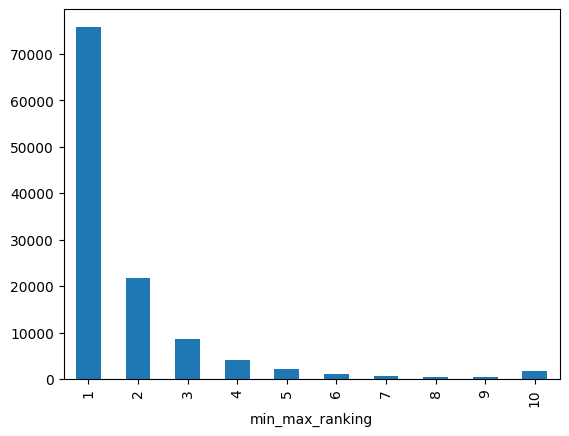

In [147]:
import matplotlib.pyplot as plt
transformed_df[transformed_df['min_max_ranking'] != 0].groupby('min_max_ranking')['game_id'].count().plot(kind='bar')
plt.show()

In [91]:
transformed_df[(transformed_df['min_max_ranking'] == 0) & (transformed_df['ranking'] !=0)]

,user_id,game_id,ranking,min_max_ranking
1,76561198256283584,271590,3415,0
9,76561198256283584,292030,5282,0
10,76561198256283584,72850,8993,0
44,76561198256283584,489830,586,0
51,76561198256283584,413150,5020,0
...,...,...,...,...
28399234,76561198027554256,400240,206,0
28399235,76561198027554256,227100,341,0
28399255,76561198027554256,224220,261,0
28399334,76561198027554256,440760,125,0


In [93]:
transformed_df[transformed_df['game_id'] == 271590].sort_values(by = 'ranking', ascending=False)

,user_id,game_id,ranking,min_max_ranking
23091701,76561198080995744,271590,751046,10
5747951,76561198194266720,271590,680454,9
904651,76561198055099152,271590,652216,8
21731951,76561198095418704,271590,587457,7
21743051,76561198048834048,271590,587162,7
...,...,...,...,...
17887651,76561198882380304,271590,0,0
17883951,76561198381118672,271590,0,0
17882101,76561198021891424,271590,0,0
17880251,76561198071545216,271590,0,0


In [94]:
transformed_df[transformed_df['min_max_ranking'] != 0].describe().astype(int)

,user_id,game_id,ranking,min_max_ranking
count,116705,116705,116705,116705
mean,76561198120425184,566911,22312,1
std,181827690,451363,71680,1
min,76561197960330608,10,253,1
25%,76561198026862848,238010,1789,1
50%,76561198066208336,413420,3802,1
75%,76561198132822944,813630,11614,2
max,76561199486167776,2369390,2359306,10


In [95]:
from scipy.sparse import csr_matrix

user_game_interaction = pd.pivot_table(transformed_df, index='user_id', columns='game_id', values='min_max_ranking')
# fill missing values with 0
user_game_interaction = user_game_interaction.fillna(0)
user_id = list(user_game_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
# convert to csr matrix
user_game_interaction_csr = csr_matrix(user_game_interaction.values)


In [149]:
user_game_interaction.head(5)

game_id,10,20,30,50,70,80,100,130,220,240,...,1966900,1973530,1974050,1997040,2050650,2064650,2066020,2208920,2221490,2369390
user_id,,,,,,,,,,,,,,,,,,,,,
76561197960278432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960330608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960430832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960631120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960664544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
games = pd.read_csv('data/games_df_no_reviews.csv')
games.head(2)

,Unnamed: 0,Name,Date,Developer,Publisher,Genre,Price,Langs,DLC,Mature,Single,Total Review Cnt,Pos Review Cnt,Neg Review Cnt,Score,appid,description,Tags
0,0.0,Senren＊Banka,"14 Feb, 2020",YUZUSOFT,HIKARI FIELD,"['Adventure', 'Casual']","29,99€","['English', 'Japanese', 'Simplified Chinese', ...",0.0,1.0,1.0,14158.0,14033.0,125.0,0.963524,1144400.0,Senren＊Banka is a Japanese-style visual novel ...,"['Visual Novel', 'Casual', 'Adventure', 'Datin..."
1,1.0,A Short Hike,"30 Jul, 2019",adamgryu,adamgryu,"['Adventure', 'Indie']","6,59€","['English', 'French', 'Spanish - Latin America...",0.0,0.0,1.0,13541.0,13442.0,99.0,0.964582,1055540.0,"Hike, climb, and soar through the peaceful mou...","['Adventure', 'Exploration', 'Indie', 'Cute', ..."


In [40]:
item_dict ={}
games = games[['appid', 'Name']].sort_values('appid').reset_index()
games['appid'] = games['appid'].astype(int)

for i in range(games.shape[0]):
    item_dict[(games.loc[i,'appid'])] = games.loc[i,'Name']

### Model Training

In [29]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM

/Users/vasevooo/projects/GameBuddy/steam/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [137]:
model = LightFM(loss='bpr',
                random_state=42,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(user_game_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [68]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=None))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    try: 
        known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    except KeyError: 
        known_items = [item_dict[x] if x in item_dict else x for x in known_items]

    try:
        scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    except KeyError: 
        scores = [item_dict[x] if x in item_dict else x for x in return_score_list]
    
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + str(i))
            counter+=1

In [138]:
sample_recommendation_user(model, user_game_interaction, 76561197960330608, user_dict, item_dict, threshold = 1, nrec_items = 5)

User: 76561197960330608
Known Likes:
1- GWENT: The Witcher Card Game
2- Skul: The Hero Slayer
3- DUSK
4- Book of Demons
5- Realm of the Mad God Exalt

 Recommended Items:
1- 364470
2- 1172470
3- God of War
4- Thronebreaker: The Witcher Tales
5- Enter the Gungeon


In [101]:
user_game_interaction['user_id'] > 0

game_id,10,20,30,50,70,80,100,130,220,240,...,1966900,1973530,1974050,1997040,2050650,2064650,2066020,2208920,2221490,2369390
user_id,,,,,,,,,,,,,,,,,,,,,
76561197960278432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960330608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
transformed_df[transformed_df['min_max_ranking'] != 0].groupby('user_id')['game_id'].count()

user_id
76561197960330608     9
76561197960430832     5
76561197960631120     2
76561197960664544    13
76561197960942800     2
                     ..
76561199264726096    18
76561199267596688     1
76561199345238976     3
76561199383675872     1
76561199486167776     1
Name: game_id, Length: 13917, dtype: int64

In [130]:
# Assuming your DataFrame is named 'transformed_df'

# Filter out rows where 'min_max_ranking' is not equal to 0
filtered_df = transformed_df[transformed_df['min_max_ranking'] != 0]

# Group by 'user_id' and count the occurrences of 'game_id'
count_df = filtered_df.groupby('user_id')['game_id'].count()

# Filter the count DataFrame based on the count condition
selected_user_ids = count_df[(count_df >= 5) & (count_df <= 10)].index
selected_user_ids

Index([76561197960330608, 76561197960430832, 76561197961788176,
       76561197962763648, 76561197963425280, 76561197963640816,
       76561197968375792, 76561197968868432, 76561197970189104,
       76561197970281088,
       ...
       76561199131554064, 76561199140139792, 76561199155251952,
       76561199167817472, 76561199186562720, 76561199191800752,
       76561199191879632, 76561199204881248, 76561199214563584,
       76561199228653792],
      dtype='int64', name='user_id', length=5084)

In [144]:
N = 10
for user in selected_user_ids[:10]: 
    print( sample_recommendation_user(model, user_game_interaction, user, user_dict, item_dict, threshold = 0, nrec_items = 5))
    print (f'-'*20)

User: 76561197960330608
Known Likes:
1- God of War
2- GWENT: The Witcher Card Game
3- 1172470
4- Skul: The Hero Slayer
5- Thronebreaker: The Witcher Tales
6- DUSK
7- Book of Demons
8- 364470
9- Realm of the Mad God Exalt

 Recommended Items:
1- Enter the Gungeon
2- Barony
3- Loop Hero
4- Heroes of Might & Magic V
5- Albion Online
None
--------------------
User: 76561197960430832
Known Likes:
1- Days Gone
2- ELDEN RING
3- Portal Knights
4- Elite Dangerous
5- Stellaris

 Recommended Items:
1- 9930
2- 22330
3- DEATH STRANDING DIRECTOR'S CUT
4- METAL GEAR SURVIVE
5- Soulstone Survivors
None
--------------------
User: 76561197961788176
Known Likes:
1- HITMAN 3
2- A Way Out
3- 863550
4- Life is Strange 2
5- Broforce
6- Grand Theft Auto V
7- The Wolf Among Us
8- 236870
9- 234710
10- Team Fortress Classic

 Recommended Items:
1- Two Point Hospital
2- 21970
3- Age of Empires® III (2007)
4- 24720
5- 780100
None
--------------------
User: 76561197962763648
Known Likes:
1- 814380
2- Slay the Spire